### 1.背景描述
  本项目的主题是探究加密货币和股票价格的相关性和对加密货币收盘价格进行预测。选择了9种加密货币，代码分别为ADA、BTC、DOGE、ETH、LTC、TRX、XLM、XRP和XVG，以及9种股票的数据进行分析。主要分析以上金融产品的收盘价格，并挖掘加密货币和股票价格之间的相关性，最后再使用机器学习的方法对加密货币的收盘价预测，并评估预测的效果。

### 2.数据获取
  加密货币的数据以txt文件的形式给出，数据维度包括：数据索引index、时间戳time、正面情感positive_sentiment、负面情感negative_sentiment、综合情感combined_sentiment、正面推文数量positive_tweets_num、负面推文数量negative_tweets_num、正面/负面推文比率tweets_ratio、英文推文数量english_tweets_volumn、非英文推文数量non_english_tweets_volumn、合计推文数量total_tweets_volumn，收盘价price_close，高点价格price_high、低点价格price_low、开盘价price_open、售出sell_volumn、买入buy_volumn等等，前半部分维度主要包括金融文本情感方面的数据，后半部分维度和价格相关，由于需要提取收盘价的相关信息，因此数据需要进一步清洗和筛选。股票的数据以csv文件的形式给出，数据维度包括时间time和收盘价price_close组成。
  加密货币和股票数据收盘价格的读取过程如下：

In [4]:
import pandas as pd

quity_file = 'stock.csv'
currency_files = [
    'ADA.txt','BTC.txt','DOGE.txt','ETH.txt','LTC.txt','TRX.txt','XLM.txt','XRP.txt','XVG.txt'
]
columns = [
    'index','time','positive_sentiment','negative_sentiment','combined sentiment','positive_tweets_num',
    'negative_tweets_num','tweets_ratio','english_tweets_volumn','non_english_tweets_volumn','total_tweets_volumn',
    'price_close','price_high','price_low','price_open','sell_volumn','buy_volumn',
    'xxx01','xxx02','xxx03','xxx04','xxx05'
]
currency = []
currency_names = [x.split('.')[0] for x in currency_files]
stock_names = ['s' + str(i) for i in range(9)]
stock = None
print('Reading data...')
for i in range(len(currency_files)):
    data = pd.read_table(currency_files[i], names=columns, encoding='utf-8', sep=',')
    currency.append(data)
tmp_list = [str(i) for i in range(0, 9)]
tmp_list.insert(0, 'time')
stock = pd.read_csv(quity_file, names=tmp_list)
stock['time'] = stock['time'].apply(lambda x: x.replace('\t', ''))
print('Cryptocurrency & Stock data are loaded.')
print('Their scales are:')
for i in range(9):
    print(currency_names[i] + ':' + str(len(currency[i])))
for i in range(9):
    print(stock_names[i] + ':' + str(len(stock['time'].values)))

Reading data...
Cryptocurrency & Stock data are loaded.
Their scales are:
ADA:3920
BTC:33187
DOGE:3919
ETH:25013
LTC:33187
TRX:3920
XLM:3919
XRP:29779
XVG:3920
s0:7234
s1:7234
s2:7234
s3:7234
s4:7234
s5:7234
s6:7234
s7:7234
s8:7234


### 3.数据预处理
  从这些数据的样本规模可以看出，加密货币的样本条数并不整齐一致，因此需要统一其时间戳，股票样本数量虽然一致，但和加密货币的数据并不能直接对应。为了方便后面的分析，这步将所有数据的共同交易日提取出来，作为分析数据。
  加密货币数据中同一天可能包含多条数据，因此进行了去重，选择同一天第一条数据作为该天的数据。另外，使用集合的交集方法选取共同交易日下的数据。经过处理之后，得到了115个共同交易日下的加密货币和股票收盘价数据，为了提高下次加载的性能，将数据保存成npy格式便于直接加载。
  由于相关性是趋势相关，需要消除样本数据值大小带来的影响。因此在这一步中，还提供了标准化和标准化逆变换的操作，使用的是Min-Max标准化。
  以下是提取共同交易日和标准化操作：

In [5]:
import copy, os, time
import numpy as np

print('Processing data...')
currency_time = []
data_time = []
stock_data = []
currency_data = []
if not os.path.exists('currency.npy') or not os.path.exists('stock.npy'):
    time_tmp = []
    for i in range(len(currency_files)):
        print(currency_files[i])
        # convert to Day-Month-Year type
        currency[i]['time'] = currency[i]['time'].apply(lambda x: time.strftime('%d-%b-%Y', time.localtime(int(x))))
        time_str = None
        last_time = None
        j, n = 0, 0
        # find the common trading day
        while j < len(currency[i]):
            time_str = currency[i].iloc[j]['time']
            # remove the duplicated date
            if time_str == last_time:
                currency[i].drop(labels=n, inplace=True)
                j -= 1
            else:
                last_time = time_str
                time_tmp.append(last_time)
            j += 1
            n += 1
        if len(currency_time) < 1:
            currency_time = copy.deepcopy(time_tmp)
        else:
            currency_time = list(set(currency_time)&set(time_tmp))
    data_time = list(set(currency_time)&set(stock['time'].tolist()))
    # select the close price as the factor
    for i in range(len(currency_files)):
        currency[i] = currency[i][currency[i]['time'].isin(data_time)]
        currency_data.append(np.array(currency[i]['price_close'].tolist()))
    stock = stock[stock['time'].isin(data_time)]
    print('Stock data summary:')
    print(stock)
    for i in range(9):
        stock_data.append(stock[str(i)].tolist())
    # Store the data into npy files
    np.save('currency.npy', np.array(currency_data))
    np.save('stock.npy', np.array(stock_data))
    np.save('time.npy', np.array(data_time))
else:
    # Load the data from npy files
    currency_data = np.load('currency.npy', allow_pickle=True)
    stock_data = np.load('stock.npy', allow_pickle=True)
    date_time = np.load('time.npy', allow_pickle=True)
print('Data processing is done.')
print(currency_data.shape)
print(stock_data.shape)

Processing data...
Data processing is done.
(9, 115)
(9, 115)


In [6]:
# Min-Max normalization
def minmax(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
# inverse transform
def minmax_inverse(x, xmax, xmin):
    return x * (xmax - xmin) + xmin

### 4.数据分析
  本节将使用5种方法对加密货币和股票价格的相关性进行分析，分别是皮尔逊相关系数，格兰杰因果关系、动态时间扭曲、KL散度和瞬时相位同步。首先使用皮尔逊相关系数，确定相关系数大于阈值的组合，使用格兰杰因果进行进一步筛选，满足其因果关系的组合寻找动态时间扭曲中的最小距离，最小KL散度，滚动窗口滞后交叉相关性的更高相关性和瞬时相位同步更高的同步性，结合以上的结果，确定出最相关的加密货币和股票组合。

### 4.1相关系数
  在统计学中，皮尔森相关系数用来衡量两个变量x和y之间的线性相关程度，其值在-1到1之间，两个变量之间的皮尔森相关系数定义为这两个变量的协方差和标准差的商数。
  计算并绘制相关系数：

=========== 代码及可视化 ===============

[]

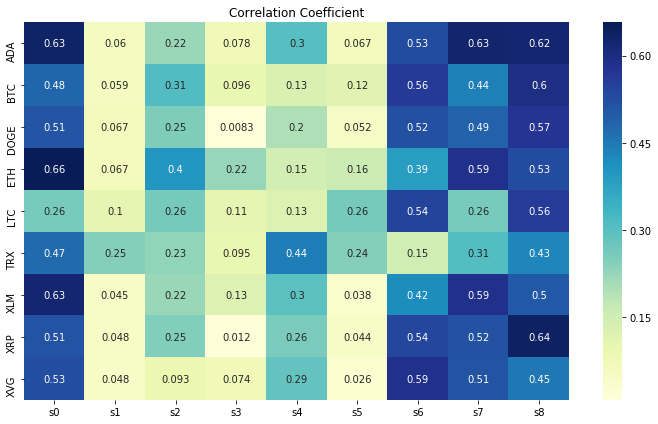

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot the correlation coefficient of these series
matrix = []
# calculate the correlation coefficient
for i in range(len(currency_data)):
    temp = []
    a = pd.Series(minmax(currency_data[i]))
    for j in range(len(stock_data)):
        b = pd.Series(minmax(stock_data[j]))
        temp.append(np.abs(a.corr(b)))
    matrix.append(temp)
# plot the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap='YlGnBu')
ax.set_xticklabels(stock_names)
ax.set_yticklabels(currency_names)
plt.title('Correlation Coefficient')
plt.tight_layout()
plt.plot()

============ 分析 ============

可以看到，相关系数的分布比较有特点，高相关系数主要分布于s0和s6-s8与货币的组合中。

### 4.2格兰杰因果（主要是必要的检验过程，因此无可视化试图）
  格兰杰因果这种方法需要保证序列的平稳性，因此使用ADF检验来确定序列的平稳性。ADF检验的原理是，如果检验值小于1%的临界值，则满足平稳的特性。而如果这些序列出现了不平稳序列，则需要在执行格兰杰因果之前对所有序列都进行差分操作，以保证序列的一致。
  ADF检验：

============ 代码 ============

In [8]:
# Perform ADF Test to confirm the stationary
import statsmodels.api as sm
def ADF_test(x, name):
    print('ADF test for ' + name + '...')
    adf = sm.tsa.stattools.adfuller(x)
    frame = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used",
                                 "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)"],
                          columns=['value'])
    frame['value']['Test Statistic Value'] = adf[0]
    frame['value']['p-value'] = adf[1]
    frame['value']['Lags Used'] = adf[2]
    frame['value']['Number of Observations Used'] = adf[3]
    # If Test value < Ctitical value, it is stationary
    frame['value']['Critical Value(1%)'] = adf[4]['1%']
    frame['value']['Critical Value(5%)'] = adf[4]['5%']
    frame['value']['Critical Value(10%)'] = adf[4]['10%']
    return frame
for i in range(len(currency_data)):
    adf = ADF_test(currency_data[i], currency_names[i]) 
    print(adf)
    print()

ADF test for ADA...
                                value
Test Statistic Value         -2.09081
p-value                      0.248227
Lags Used                           1
Number of Observations Used       113
Critical Value(1%)           -3.48959
Critical Value(5%)           -2.88748
Critical Value(10%)           -2.5806

ADF test for BTC...
                                value
Test Statistic Value         -2.04655
p-value                      0.266542
Lags Used                           1
Number of Observations Used       113
Critical Value(1%)           -3.48959
Critical Value(5%)           -2.88748
Critical Value(10%)           -2.5806

ADF test for DOGE...
                                value
Test Statistic Value         -2.53371
p-value                      0.107485
Lags Used                           3
Number of Observations Used       111
Critical Value(1%)           -3.49068
Critical Value(5%)           -2.88795
Critical Value(10%)          -2.58086

ADF test for ETH...
    

  从运行结果中可以看出，加密货币中只有TRX和XRP是平稳的，其余都是不平稳的，而股票数据都是不平稳的。因此需要对所有数据进行一阶差分，差分操作如下：

In [9]:
# Do diff for all series until it is stationary
print('Differential operation...')
def diff(x, name):
    print('Differential operation...')
    data = pd.Series(x)
    frame = ADF_test(data, name)
    num = 0
    while frame['value']['Test Statistic Value'] >= frame['value']['Critical Value(1%)']:
        data = data.diff(1)
        data.dropna(inplace=True)
        frame = ADF_test(data, name)
        num += 1
    # To obtain the same size
    if num == 0:
        data = data.diff(1)
        data.dropna(inplace=True)
        frame = ADF_test(data, name)
    print('After differential operation ' + str(num) + ' times:')
    print(frame)
    return data

currency_diff = []
stock_diff = []
if not os.path.exists('currency_diff.npy') or not os.path.exists('stock_diff.npy'):
    for i in range(len(currency_data)):
        currency_diff.append(np.array(diff(currency_data[i], currency_names[i]).tolist()))
        print()
    for i in range(len(stock_data)):
        stock_diff.append(np.array(diff(stock_data[i], stock_names[i]).tolist()))
        print()
    currency_diff = np.array(currency_diff)
    stock_diff = np.array(stock_diff)
    np.save('currency_diff.npy', currency_diff)
    np.save('stock_diff.npy', stock_diff)
else:
    currency_diff = np.load('currency_diff.npy', allow_pickle=True)
    stock_diff = np.load('stock_diff.npy', allow_pickle=True)
print('Differential operation is done.')

Differential operation...
Differential operation is done.


  差分操作执行完后，进行格兰因果检验。格兰杰因果满足因果性的条件是p-value小于0.05，而F-value尽可能大，因此对每个组合进行最大滞后为10的格兰杰因果检验，由于因果关系不满足交换律，因此对于每个组合a，b两个元素，要检验a -> b和b -> a。
  执行格兰杰因果检验：

In [10]:
# It seem that ADA & s0, ADA & s7, ADA & s8, BTC & s6, BTC & s8,
#              DOGE & s8, ETH & s0, ETH & s7, LTC & s8,
#              XLM & s0, XLM & s7, XRP & s8 and XVG & s6 have the relatively high dependency
# Perform Granger Causality for these combinations
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality(index1, index2):
    print(currency_names[index1], stock_names[index2])
    df = pd.DataFrame()
    df[currency_names[index1]] = currency_diff[index1]
    df[stock_names[index2]] = stock_diff[index2]
    grangercausalitytests(df[[currency_names[index1], stock_names[index2]]], maxlag=10)
    grangercausalitytests(df[[stock_names[index2], currency_names[index1]]], maxlag=10)

gc_combs = [[0, 0], [0, 7], [0, 8], [1, 6], [1, 8], 
            [2, 8], [3, 0], [3, 7], [4, 8], [6, 0],
            [6, 7], [7, 8], [8, 6]]
for i in range(len(gc_combs)):
    granger_causality(gc_combs[i][0], gc_combs[i][1])

ADA s0

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7522  , p=0.0553  , df_denom=110, df_num=1
ssr based chi2 test:   chi2=3.8545  , p=0.0496  , df=1
likelihood ratio test: chi2=3.7902  , p=0.0516  , df=1
parameter F test:         F=3.7522  , p=0.0553  , df_denom=110, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5412  , p=0.5836  , df_denom=107, df_num=2
ssr based chi2 test:   chi2=1.1330  , p=0.5675  , df=2
likelihood ratio test: chi2=1.1273  , p=0.5691  , df=2
parameter F test:         F=0.5412  , p=0.5836  , df_denom=107, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9036  , p=0.4421  , df_denom=104, df_num=3
ssr based chi2 test:   chi2=2.8932  , p=0.4084  , df=3
likelihood ratio test: chi2=2.8562  , p=0.4143  , df=3
parameter F test:         F=0.9036  , p=0.4421  , df_denom=104, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4098  , p=0

likelihood ratio test: chi2=9.5960  , p=0.2126  , df=7
parameter F test:         F=1.2332  , p=0.2929  , df_denom=92, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8888  , p=0.5294  , df_denom=89, df_num=8
ssr based chi2 test:   chi2=8.4685  , p=0.3891  , df=8
likelihood ratio test: chi2=8.1472  , p=0.4192  , df=8
parameter F test:         F=0.8888  , p=0.5294  , df_denom=89, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9671  , p=0.4729  , df_denom=86, df_num=9
ssr based chi2 test:   chi2=10.6266 , p=0.3022  , df=9
likelihood ratio test: chi2=10.1226 , p=0.3406  , df=9
parameter F test:         F=0.9671  , p=0.4729  , df_denom=86, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8798  , p=0.5553  , df_denom=83, df_num=10
ssr based chi2 test:   chi2=11.0242 , p=0.3556  , df=10
likelihood ratio test: chi2=10.4781 , p=0.3996  , df=10
parameter F test:         F=0.8798  , p=0

parameter F test:         F=0.6166  , p=0.6874  , df_denom=98, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5921  , p=0.7359  , df_denom=95, df_num=6
ssr based chi2 test:   chi2=4.0387  , p=0.6714  , df=6
likelihood ratio test: chi2=3.9650  , p=0.6814  , df=6
parameter F test:         F=0.5921  , p=0.7359  , df_denom=95, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9110  , p=0.0766  , df_denom=92, df_num=7
ssr based chi2 test:   chi2=15.5582 , p=0.0295  , df=7
likelihood ratio test: chi2=14.5260 , p=0.0426  , df=7
parameter F test:         F=1.9110  , p=0.0766  , df_denom=92, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6592  , p=0.1196  , df_denom=89, df_num=8
ssr based chi2 test:   chi2=15.8093 , p=0.0452  , df=8
likelihood ratio test: chi2=14.7359 , p=0.0645  , df=8
parameter F test:         F=1.6592  , p=0.1196  , df_denom=89, df_num=8

Granger Causality
number of

number of lags (no zero) 5
ssr based F test:         F=0.6769  , p=0.6419  , df_denom=98, df_num=5
ssr based chi2 test:   chi2=3.7644  , p=0.5838  , df=5
likelihood ratio test: chi2=3.7008  , p=0.5932  , df=5
parameter F test:         F=0.6769  , p=0.6419  , df_denom=98, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6762  , p=0.6692  , df_denom=95, df_num=6
ssr based chi2 test:   chi2=4.6122  , p=0.5944  , df=6
likelihood ratio test: chi2=4.5165  , p=0.6071  , df=6
parameter F test:         F=0.6762  , p=0.6692  , df_denom=95, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1151  , p=0.3605  , df_denom=92, df_num=7
ssr based chi2 test:   chi2=9.0781  , p=0.2471  , df=7
likelihood ratio test: chi2=8.7135  , p=0.2739  , df=7
parameter F test:         F=1.1151  , p=0.3605  , df_denom=92, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1424  , p=0.3433  , df_denom=89, df_num=8
s

parameter F test:         F=0.4238  , p=0.9313  , df_denom=83, df_num=10
LTC s8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9993  , df_denom=110, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9993  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9993  , df=1
parameter F test:         F=0.0000  , p=0.9993  , df_denom=110, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3203  , p=0.7267  , df_denom=107, df_num=2
ssr based chi2 test:   chi2=0.6704  , p=0.7152  , df=2
likelihood ratio test: chi2=0.6684  , p=0.7159  , df=2
parameter F test:         F=0.3203  , p=0.7267  , df_denom=107, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3147  , p=0.8147  , df_denom=104, df_num=3
ssr based chi2 test:   chi2=1.0078  , p=0.7994  , df=3
likelihood ratio test: chi2=1.0032  , p=0.8005  , df=3
parameter F test:         F=0.3147  , p=0.8147  , df_denom=104, df_num=3

Granger Causa

ssr based F test:         F=2.9191  , p=0.0117  , df_denom=95, df_num=6
ssr based chi2 test:   chi2=19.9111 , p=0.0029  , df=6
likelihood ratio test: chi2=18.2740 , p=0.0056  , df=6
parameter F test:         F=2.9191  , p=0.0117  , df_denom=95, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9035  , p=0.5074  , df_denom=92, df_num=7
ssr based chi2 test:   chi2=7.3554  , p=0.3928  , df=7
likelihood ratio test: chi2=7.1136  , p=0.4171  , df=7
parameter F test:         F=0.9035  , p=0.5074  , df_denom=92, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8711  , p=0.5439  , df_denom=89, df_num=8
ssr based chi2 test:   chi2=8.3002  , p=0.4047  , df=8
likelihood ratio test: chi2=7.9913  , p=0.4343  , df=8
parameter F test:         F=0.8711  , p=0.5439  , df_denom=89, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7163  , p=0.6925  , df_denom=86, df_num=9
ssr based chi2 test:   chi2=

parameter F test:         F=2.1388  , p=0.0671  , df_denom=98, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7224  , p=0.1241  , df_denom=95, df_num=6
ssr based chi2 test:   chi2=11.7487 , p=0.0678  , df=6
likelihood ratio test: chi2=11.1525 , p=0.0838  , df=6
parameter F test:         F=1.7224  , p=0.1241  , df_denom=95, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4927  , p=0.1796  , df_denom=92, df_num=7
ssr based chi2 test:   chi2=12.1522 , p=0.0957  , df=7
likelihood ratio test: chi2=11.5103 , p=0.1179  , df=7
parameter F test:         F=1.4927  , p=0.1796  , df_denom=92, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1597  , p=0.3325  , df_denom=89, df_num=8
ssr based chi2 test:   chi2=11.0493 , p=0.1989  , df=8
likelihood ratio test: chi2=10.5106 , p=0.2310  , df=8
parameter F test:         F=1.1597  , p=0.3325  , df_denom=89, df_num=8

Granger Causality
number of

### 4.3动态时间扭曲（规整）
  动态时间扭曲可用于计算两个时间序列的相似度，采用了动态规划的思想来对时间规整进行计算，原理是求解两个序列匹配累计距离最小时的规整函数，最终返回规整路径。因此可以通过比较累计距离来判断两个序列的相关程度。
  这里使用的是经标准化之后的数据，计算动态时间扭曲最小累计距离:

=========== 代码及可视化 ===============

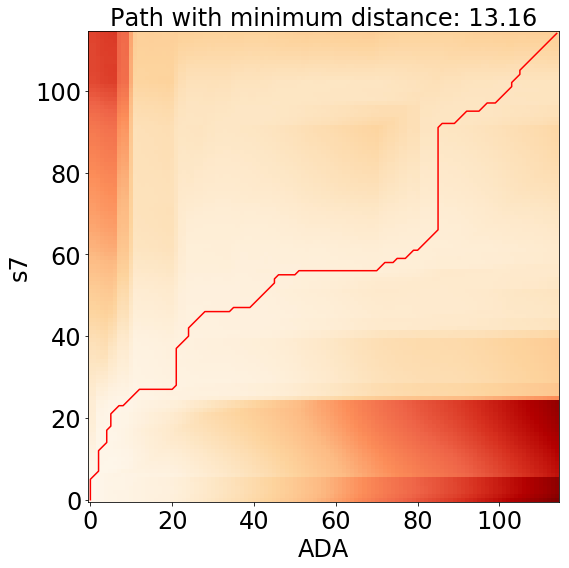

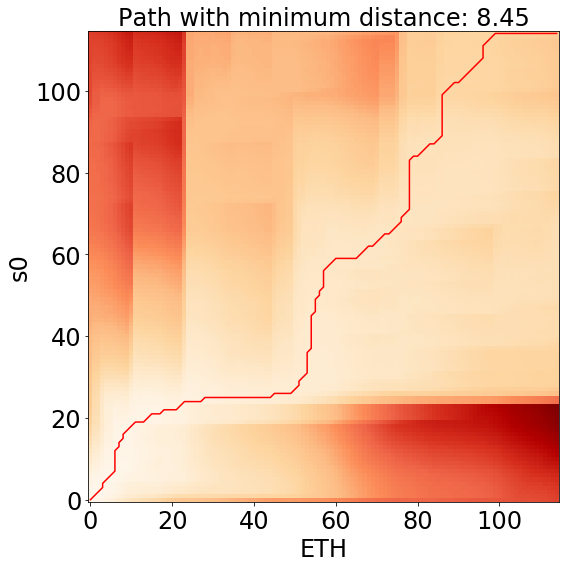

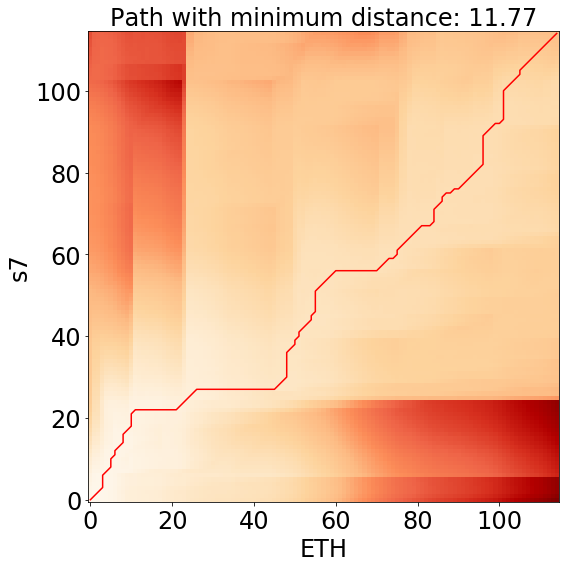

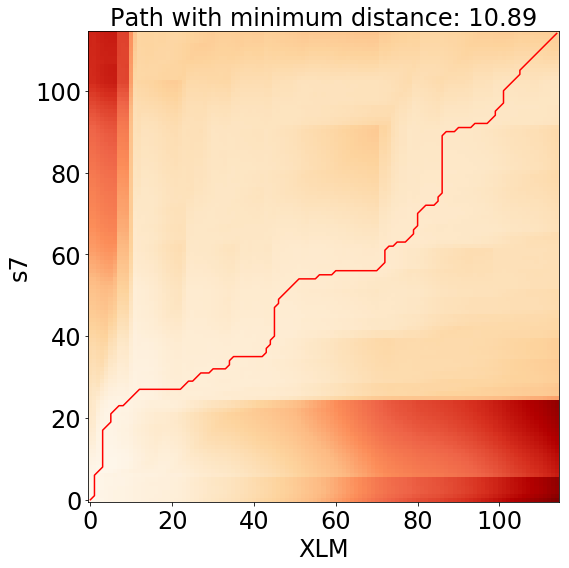

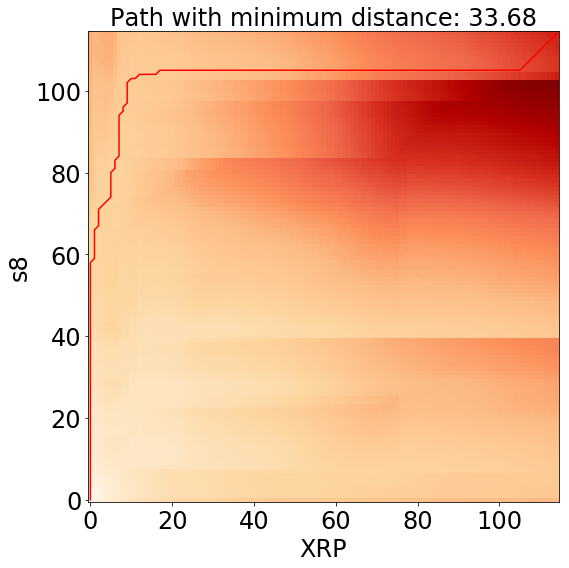

In [15]:
# From the Granger Causality, we find that ADA & s7, ETH & s0, ETH & s7, XLM & s7 and XRP & s8 has the p-value < 0.05
# Plot figure of dynamic_time_warping
from dtw import dtw,accelerated_dtw
def dynamic_time_warping(index1, index2):
    plt.figure(figsize=(8, 8))
    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(minmax(currency_data[index1]), minmax(stock_data[index2]), dist='euclidean')
    plt.imshow(acc_cost_matrix.T, origin='lower', cmap='OrRd', interpolation='nearest')
    plt.plot(path[0], path[1], 'r')
    plt.xlabel(currency_names[index1], fontsize=24)
    plt.ylabel(stock_names[index2], fontsize=24)
    plt.tick_params(labelsize=24)
    plt.title(f'Path with minimum distance: {np.round(d,2)}', fontsize=24)
    plt.tight_layout()
    plt.plot()
# 13.16, 8.45, 11.77, 10.89, 33.68
dtw_combs = [[0, 7], [3, 0], [3, 7], [6, 7], [7, 8]]
for i in range(len(dtw_combs)):
    dynamic_time_warping(dtw_combs[i][0], dtw_combs[i][1])

============ 分析 ============

  可以从累计距离看到ETH&s0, ETH&s7和XLM&s7具有较高的相似度，最短累计距离分别是8.45, 11.77和10.89。

### 4.4KL散度
  KL散度是用来量化两种概率分布之间的差异的方式，又名相对熵。两个序列的相关性高低也可以通过比较KL-散度来得到，尤其是对于离散数据，可以衡量其分布的距离。
  与变量的相互信息不同，它是用来衡量两个取正值的函数的相似度。如果两个函数相同，那么它们的相对熵为0，相对熵越大，两个函数之间的差值越大。相对熵越小，两个函数之间的差值越小。对于概率分布或概率密度函数(>0)，相对熵是衡量两个随机分布之间的差值，如果两个随机分布的值都大于0，则两个函数的相对熵就可以衡量两个随机分布的差异。这符合收盘价格的特征。
  这里使用的是经标准化之后的数据，先计算两个序列的概率分布，然后计算并绘制KL散度：

=========== 代码及可视化 ===============

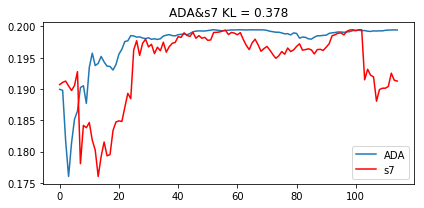

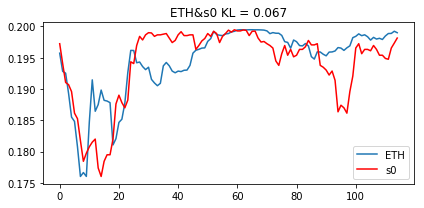

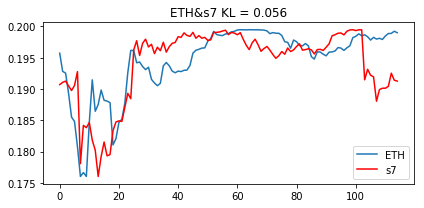

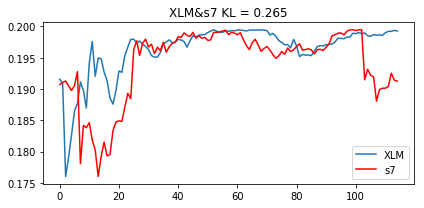

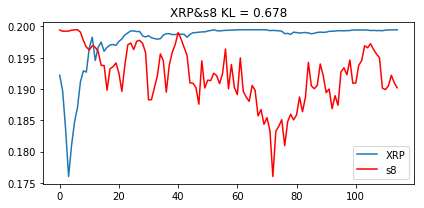

In [16]:
# KL Divergence
from scipy.stats import norm
def kl_divergence(index1, index2):
    currency = minmax(currency_data[index1])
    stock = minmax(stock_data[index2])
    name1 = currency_names[index1]
    name2 = stock_names[index2]
    p = norm.pdf(currency, 0, 2)
    q = norm.pdf(stock, 0, 2)
    res = np.sum(p * np.log(p / q))
    plt.figure(figsize=(6, 3))
    plt.title(name1 + '&' + name2 + ' KL = %1.3f' % res)
    plt.plot(p, label=currency_names[index1])
    plt.plot(q, c='red', label=stock_names[index2])
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
# 0.378, 0.067, 0.056, 0.265, 0.678    
kl_combs = [[0, 7], [3, 0], [3, 7], [6, 7], [7, 8]]
for i in range(len(kl_combs)):
    kl_divergence(dtw_combs[i][0], dtw_combs[i][1])

============ 分析 ============

  可以看到还是ETH&s0, ETH&s7和XLM&s7这3个组合具有较小的分布距离，KL散度值分别是0.056, 0.067和0.265。

### 4.5动态加窗时间滞后交叉相关系数（WTLCC）
  时滞交叉相关可以定义两个信号的方向性，如引导-跟随关系，其中引导信号初始化了一个响应，下面的信号重复了这个响应。如果相关性的峰值位于中心点（当偏移量=0时），则表示两个序列在这一点上具有最高的相关性。但是，如果一个信号引导另一个信号，则相关度的峰值可能位于不同的坐标值。为了在更细的粒度上估计动态变化，用滚动窗口计算时滞交叉相关。这个过程反复计算多个时间窗口内的交叉相关性。取每个窗口的总和，得到一个比较领导信号和跟随信号之间的交互性差异的得分。
  这里使用的是经标准化之后的数据，计算并绘制ETH&s0, ETH&s7和XLM&s7这3个组合的WTLCC：

=========== 代码及可视化 ===============

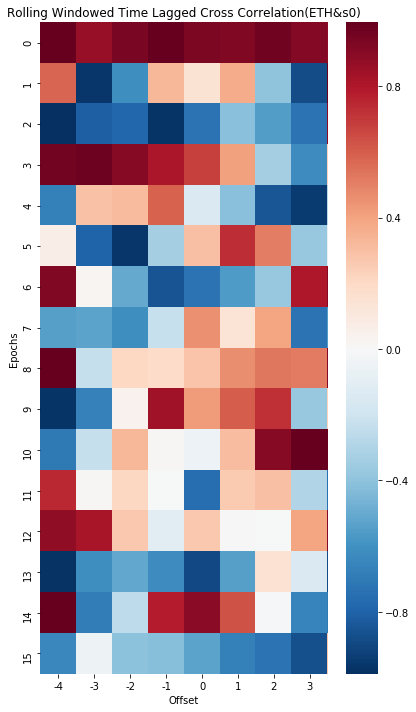

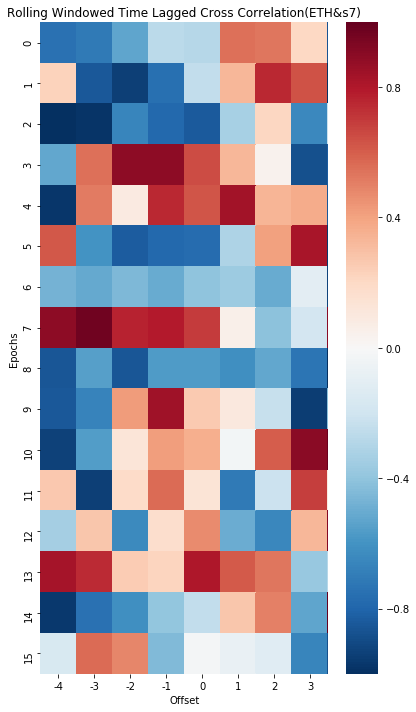

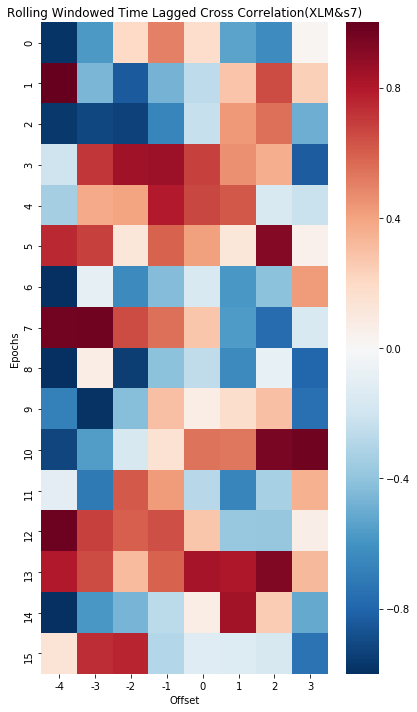

In [10]:
# Rolling windowed time lagged cross correlation
# ETH & s0, ETH & s7, XLM & s7 have the shorter distance and smaller KL values
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

def wtlcc(index1, index2):
    samples = 5
    window_size = 7
    t_start = 0
    t_end = t_start + window_size
    step_size = 7
    rss=[]
    while t_end < 114:
        d1 = pd.Series(minmax(currency_data)[index1][t_start:t_end])
        d2 = pd.Series(minmax(stock_data)[index2][t_start:t_end])
        rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(samples - 1),int(samples))]
        rss.append(rs)
        t_start = t_start + step_size
        t_end = t_end + step_size
    rss = pd.DataFrame(rss)
    f,ax = plt.subplots(figsize=(6, 10))
    sns.heatmap(rss,cmap='RdBu_r',ax=ax)
    name1 = currency_names[index1]
    name2 = stock_names[index2]
    ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation(' + name1 + '&' + name2 + ')', xlim=[0, 8], xlabel='Offset',ylabel='Epochs')
    ax.set_xticklabels([int(item - 4.5) for item in ax.get_xticks()])
    plt.tight_layout()
    plt.show()
    
cc_combs = [[3, 0], [3, 7], [6, 7]]
for i in range(len(cc_combs)):
    wtlcc(cc_combs[i][0], cc_combs[i][1])

============ 分析 ============

ETH和s0之间的时滞交叉相关性图中，可以看到，ETH在早期阶段起着主导作用，最强的相互作用出现在第0和第3个时间步。那么，时间步>5时，s0开始在交互作用中发挥作用，在偏移量=0时呈现出密切的相关性。
XLM&s7和ETH&s7的交叉相关性图中表示强的相互作用和高相关度的深色格点较少。在这三种组合中，具有更多深色格点的ETH&s0的相关性最高。综上所述，时滞滚动窗口的交叉相关性是一种有效的评估相关性的方法，可以更精细地观察两个信号之间的动态相互作用和如何随时间变化。

### 4.6瞬时相位同步
  之后，通过瞬时相位同步计算上述3个组合在每个时刻的同步性。瞬时相位同步是一种通过提取信号的相位来计算相位同步的方法，这个过程可以通过希尔伯特变换来完成。希尔伯特变换将信号的相位和能量分离出来，这样就可以评估两个信号是否处于同一相位。
  计算瞬时相位同步及绘制：

=========== 代码及可视化===============

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


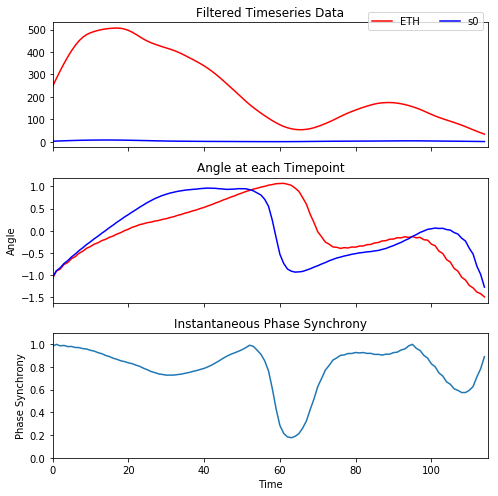

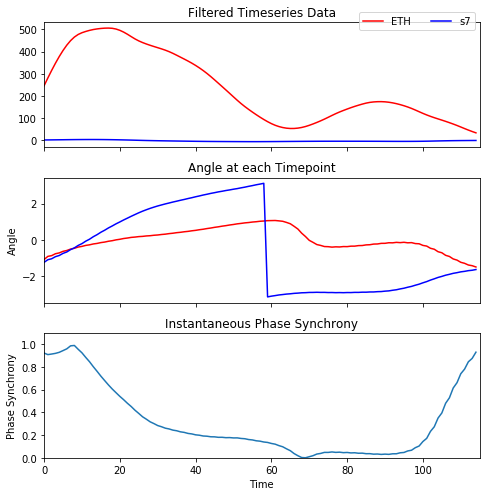

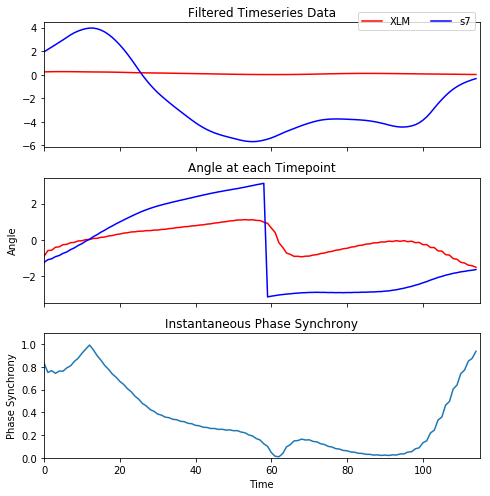

In [11]:
# Instantaneous Phase Synchrony
from scipy.signal import hilbert, butter, filtfilt
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def phase(index1, index2):
    lowcut  = .01
    highcut = .5
    fs = 30.
    order = 1
    d1 = currency_data[index1]
    d2 = stock_data[index2]
    y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    N = len(al1)
    f,ax = plt.subplots(3,1,figsize=(7,7),sharex=True)
    ax[0].plot(y1,color='r',label=currency_names[index1])
    ax[0].plot(y2,color='b',label=stock_names[index2])
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
    ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
    ax[1].plot(al1,color='r')
    ax[1].plot(al2,color='b')
    ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    ax[2].plot(phase_synchrony)
    ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
    plt.tight_layout()
    plt.plot()
    
p_combs = [[3, 0], [3, 7], [6, 7]]
for i in range(len(p_combs)):
    phase(p_combs[i][0], p_combs[i][1])

============ 分析 ============

  上面和中间的子图是经过滤波和分解后的时间序列，下面的子图是相位同步。除60附近的点外，ETH和s0基本处于同一相位。也就是说，它们的变化趋势是相关的。可以得出结论，ETH和s0具有较高的相关性。

### 4.7使用SVR方法对加密货币收盘价格进行预测
  下面的主题是对加密货币的时间序列进行预测，选择了支持向量回归（SVR）的方法进行预测。SVR模型利用SVM进行曲线拟合，并进行回归分析。与分类模型的输出是有限的离散值不同，回归模型的输出是在一定范围内连续的。因此需要读取加密货币的原始数据，并在训练之前需要对时间序列进行归一化处理，通过滚动机制将其分组成对。然后将这些数组对送入SVR模型进行训练。在本例中，4/5的序列用于训练，1/5的序列用于测试。为了确定每个输入的长度，绘制出系列的自相关系数ACF和偏自相关系数PACF，以找到一个合适的长度。在本节中，对ETH的收盘价格进行预测。
  首先计算并绘制ACF和PACF：

=========== 代码及可视化展示===============

Reading ETH original data...


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


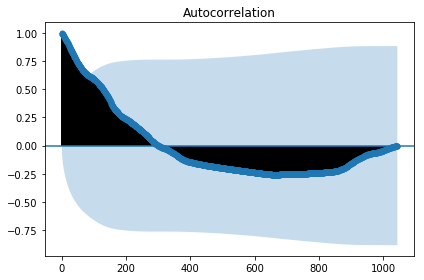

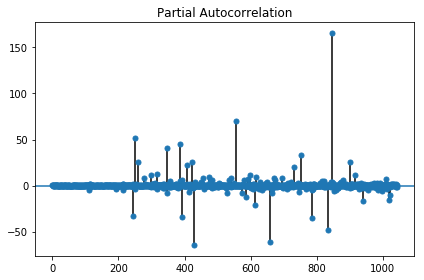

In [12]:
# ACF_PACF of ETH
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
def ACF_PACF(data):
    plot_acf(data)
    plt.tight_layout()
    plt.plot()
    plot_pacf(data)
    plt.tight_layout()
    plt.plot()
    
print('Reading ETH original data...')
eth = pd.read_table('ETH.txt', names=columns, encoding='utf-8', sep=',')
eth['time'] = eth['time'].apply(lambda x: time.strftime('%d-%b-%Y', time.localtime(int(x))))
time_str = None
last_time = None
j, n = 0, 0
while j < len(eth):
    time_str = eth.iloc[j]['time']
    if time_str == last_time:
        eth.drop(labels=n, inplace=True)
        j -= 1
    else:
        last_time = time_str
    j += 1
    n += 1
temp = np.array(eth['price_close'].tolist())
ACF_PACF(temp)

============ 分析 ============

  由上图可以得到，输入长度应当设置为5，因为它是使PACF = 0的最小值。
  并且，选取均方根误差RMSE，平均绝对误差MAE和相关系数R^2来评估预测效果。
  训练SVR模型并执行预测，绘制图像：

=========== 代码及可视化展示===============

Training SVR model...
Name:ETH

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



RMSE:35.4010
MAE:29.3572
R2:0.6270


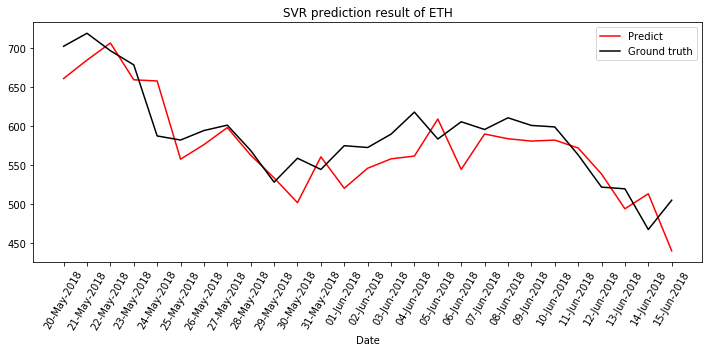

In [13]:
# Predict ETH using SVR
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
def RMSE(true, pred):
    return np.sqrt(mean_squared_error(true, pred))

def MAE(true, pred):
    return mean_absolute_error(true, pred)

def R2(true, pred):
    return r2_score(true, pred)

def cal_index(true, pred, name):
    print('Name:' + name)
    print('RMSE:%.4f' % (RMSE(true, pred)))
    print('MAE:%.4f' % (MAE(true, pred)))
    print('R2:%.4f' % (R2(true, pred)))

def svr(data, input_length, name, time):
    xmax, xmin = np.max(data), np.min(data)
    pro_data = minmax(data)
    total = data.shape[0] - input_length
    train_length = total - 28
    model = SVR(kernel='rbf', C=1e3, gamma=0.1)
    basic_data = np.zeros((total, input_length))
    next_data = np.zeros((total, 1))
    for d in range(0, total):
        for i in range(0, input_length):
            basic_data[d, i] = pro_data[d + i]
        for j in range(0, 1):
            next_data[d, j] = pro_data[d + j + input_length]
    train_x = basic_data[35:train_length + 28]
    train_y = next_data[35:train_length + 28]
    model.fit(train_x, train_y)
    output = np.zeros(total - train_length - 1)
    ground = next_data[train_length + 1:].reshape(total - train_length - 1)
    for i in range(train_length + 1, total):
        output[i - train_length - 1] = model.predict([basic_data[i]])
    output = minmax_inverse(output, xmax, xmin)
    ground = minmax_inverse(ground, xmax, xmin)
    plt.figure(figsize=(10, 5))
    plt.plot(time[train_length + input_length + 1:], output, color='red', label='Predict')
    plt.plot(time[train_length + input_length + 1:], ground, color='black', label='Ground truth')
    plt.legend()
    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.title('SVR prediction result of ' + name)
    plt.tight_layout()
    plt.plot()
    cal_index(ground, output, name)
    
print('Training SVR model...')
svr(temp, 5, 'ETH', eth['time'].tolist())

============ 分析 ============

评价指标如下：
评价指标	RMSE	MAE	R2
Value	35.4010	29.3572	0.6270
通过将预测值和真实值比较，可以看出，预测值与真实值的收盘价格变化趋势较为相近，并且评价指标的值也呈现了较低的误差，预测值和真实值的相关系数达到了0.6270，说明SVR方法适用于加密货币价格的预测。